# Ensemble
### Create and evaluate an ensemble of seperable convolutional classifiers

## Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
# # Credit: https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [3]:
import tensorflow as tf
import data
from loaders import PremadeTripletClassifierSequence
import numpy as np
import TripletClassifierEnsemble
import matplotlib.pyplot as plt

## Files

In [4]:
data_dir = '../Data/Datasets/All/'
out_dir = f'{data_dir}/Models/'


train_sequence = f'{data_dir}/train_sequences.fa'
valid_sequence = f'{data_dir}/valid_sequences.fa'
test_sequence = f'{data_dir}/test_sequences.fa'

reverse_train_sequence = f'{data_dir}/reverse_train_sequences.fa'
reverse_valid_sequence = f'{data_dir}/reverse_valid_sequences.fa'
reverse_test_sequence = f'{data_dir}/reverse_test_sequences.fa'

train_triplet_dis = f'{data_dir}/train_triplet_dis.npy'
valid_triplet_dis = f'{data_dir}/valid_triplet_dis.npy'
test_triplet_dis = f'{data_dir}/test_triplet_dis.npy'

train_triplet_sim = f'{data_dir}/train_triplet_sim.npy'
valid_triplet_sim = f'{data_dir}/valid_triplet_sim.npy'
test_triplet_sim = f'{data_dir}/test_triplet_sim.npy'

## Parameters

In [5]:
model_count = 151 # Number of models in ensemble
threshold = 0.55 # For ensemble prediction; needs this much agreement to predict a class
max_len = 600 # Maximum length of sequence

## Data

In [7]:
train = data.FantomToOneHotConverter(train_sequence, 0, max_len).seq_matrix
reverse_train = data.FantomToOneHotConverter(reverse_train_sequence, 0, max_len).seq_matrix

In [8]:
valid = data.FantomToOneHotConverter(valid_sequence, 0, max_len).seq_matrix
reverse_valid = data.FantomToOneHotConverter(reverse_valid_sequence, 0, max_len).seq_matrix

In [9]:
test = data.FantomToOneHotConverter(test_sequence, 0, max_len).seq_matrix
reverse_test = data.FantomToOneHotConverter(reverse_test_sequence, 0, max_len).seq_matrix

In [10]:
d1, d2, d3 = 4, max_len, 3

## Creating Ensemble

In [14]:
ensemble = TripletClassifierEnsemble.TripletClassifierEnsemble(out_dir, (d1, d2, d3))

In [15]:
ensemble.fit(model_count, train, reverse_train, train_triplet_sim, train_triplet_dis, valid, reverse_valid, valid_triplet_sim, valid_triplet_dis, epochs= 500, vote_metric = 'precision')
ensemble.load_models(model_count) # Loading models into memory; speeds up prediction

## Loading dataset

In [20]:
train_seq = PremadeTripletClassifierSequence(train, train_triplet_sim, train_triplet_dis, batch_size = 1024, reverse_x_in =reverse_train)
valid_seq = PremadeTripletClassifierSequence(valid, valid_triplet_sim, valid_triplet_dis, batch_size = 1024, reverse_x_in =reverse_valid)
test_seq = PremadeTripletClassifierSequence(test, test_triplet_sim, test_triplet_dis, batch_size = 1024, reverse_x_in = reverse_test)

In [21]:
def collect_data_from_loader(a_loader):
    x_list = []
    y_list = []
    for x_batch, y_batch in a_loader:
        x_list.append(x_batch)
        y_list.append(y_batch)
    x_matrix = np.concatenate(x_list)
    y_array  = np.concatenate(y_list).reshape(-1)
    return x_matrix, y_array

In [23]:
x_train, y_train = collect_data_from_loader(train_seq)
x_valid, y_valid = collect_data_from_loader(valid_seq)
x_test, y_test = collect_data_from_loader(test_seq)
print(y_train.shape, y_valid.shape, y_test.shape)

# Plotting ensemble distributions

In [27]:
def collect_output(an_ensemble, x_matrix, model_count):
    '''
    Collect predictions of a model multiple times
    '''
    with tf.device('/cpu:0'):
        output_list = []
        for i in range(model_count):
            output_list.append(an_ensemble.predict_raw(x_matrix, i, is_loaded = True))
    return output_list 

In [28]:
def evaluate_multiple_output(an_ensemble, output_list, y_true, threshold, is_merit = False):
    '''
    Evaluate 1, 3, 5, ... models
    '''
    ensemble_y_pred = [output_list[0]]
    result_list = []
    r, _ = an_ensemble.evaluate(ensemble_y_pred, y_true, threshold = threshold, is_merit = is_merit, is_loaded = True, already_predicted = True)
    result_list.append(r)
    
    
    for i in range(1, len(output_list)):
        model_count = i + 1
        if model_count%2 == 1:
            ensemble_y_pred = output_list[:model_count]
            r, _ = an_ensemble.evaluate(ensemble_y_pred, y_true, threshold = threshold, is_merit = is_merit, is_loaded = True, already_predicted = True)
            result_list.append(r)
        
    
    return np.array(result_list)    

In [46]:
def plot_ensemble(an_ensemble, x_matrix, y_true, model_count, threshold, is_merit = False, title = "", path = ""):
    '''
    Plots an ensemble's performance
    '''
    output_list = collect_output(an_ensemble, x_matrix, model_count)
    result_matrix = evaluate_multiple_output(an_ensemble, output_list, y_true, threshold, is_merit)

    plt.figure(figsize=(10, 7))
    x_values = list(range(1, model_count + 1, 2))

    plt.plot(x_values, result_matrix[:, 0], marker='s', linewidth=2, label='Accuracy')
    plt.plot(x_values, result_matrix[:, 1], marker='o', linewidth=2, label='Specificity')
    plt.plot(x_values, result_matrix[:, 2], marker='^', linewidth=2, label='Recall')
    plt.plot(x_values, result_matrix[:, 3], marker='D', linewidth=2, label='Precision')
    plt.plot(x_values, result_matrix[:, 4], marker='P', linewidth=2, label='F1 Score')

    plt.xlabel('Model Count', fontsize=18)
    plt.ylabel('Metric Values', fontsize=18)
    plt.ylim(0.0, 1.0)
    legend = plt.legend(bbox_to_anchor=(1.08, 0.875), bbox_transform=plt.gcf().transFigure, fontsize='large')
    plt.grid(True)

    # Include the legend in the saved figure
    plt.savefig(path, bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.show()


480/480 [==============================] - 3s 7ms/step
Accuracy: 0.5697916666666667
Specificity: 0.7705515088449532
Recall:  0.3686131386861314
Precision:  0.6158536585365854
F1:  0.461187214611872
Accuracy: 0.6120442708333333
Specificity: 0.9190946930280958
Recall:  0.30435349322210636
Precision:  0.7896516739939128
F1:  0.43936400413961796
Accuracy: 0.5591145833333333
Specificity: 0.9789281997918835
Recall:  0.13842544316996871
Precision:  0.8676470588235294
F1:  0.23875899280575533
Accuracy: 0.57734375
Specificity: 0.97840790842872
Recall:  0.17544316996871742
Precision:  0.8902116402116402
F1:  0.2931184668989547
Accuracy: 0.5815104166666667
Specificity: 0.9754162330905307
Recall:  0.18678310740354537
Precision:  0.8834771886559802
F1:  0.3083709920378738
Accuracy: 0.59921875
Specificity: 0.9642299687825182
Recall:  0.23344629822732013
Precision:  0.866892545982575
F1:  0.3678373382624769
Accuracy: 0.6119140625
Specificity: 0.9530437044745057
Recall:  0.27007299270072993
Precision:

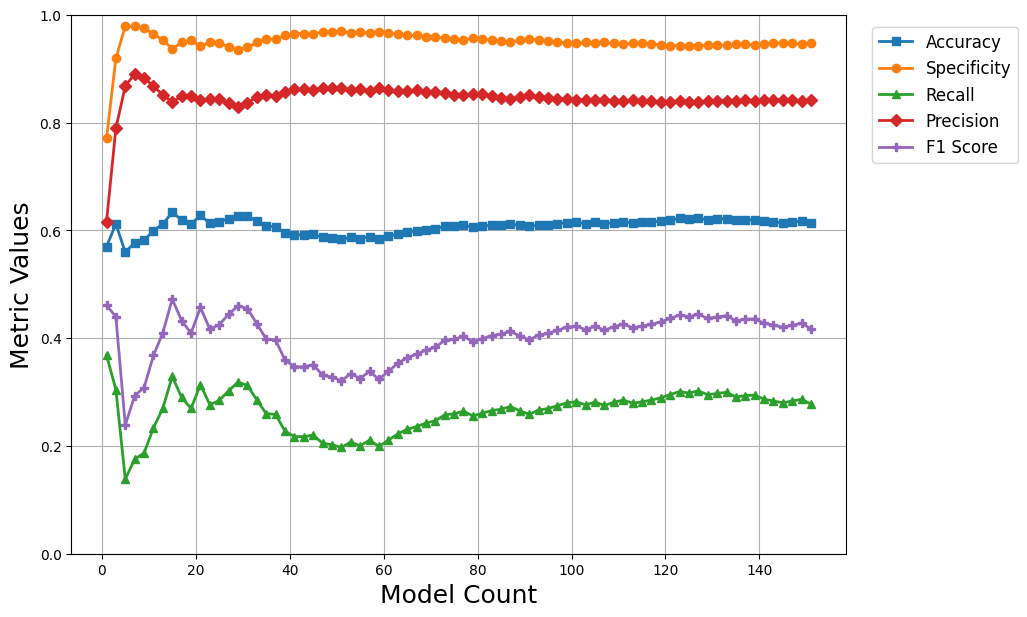

480/480 [==============================] - 3s 7ms/step
Accuracy: 0.5697916666666667
Specificity: 0.7705515088449532
Recall:  0.3686131386861314
Precision:  0.6158536585365854
F1:  0.461187214611872
Accuracy: 0.609375
Specificity: 0.9206555671175859
Recall:  0.29744525547445255
Precision:  0.789073305670816
F1:  0.43203332071185147
Accuracy: 0.5871744791666667
Specificity: 0.954474505723205
Recall:  0.21910844629822732
Precision:  0.82767109798129
F1:  0.34649077604864464
Accuracy: 0.6037760416666667
Specificity: 0.9585067637877211
Recall:  0.2483055265901981
Precision:  0.8565647482014388
F1:  0.38500404203718663
Accuracy: 0.6017578125
Specificity: 0.961888657648283
Recall:  0.24087591240875914
Precision:  0.8631480616534329
F1:  0.3766432283705288
Accuracy: 0.6197916666666666
Specificity: 0.9456295525494277
Recall:  0.293274244004171
Precision:  0.843328335832084
F1:  0.4352030947775628
Accuracy: 0.6315755208333333
Specificity: 0.9373048907388137
Recall:  0.32520855057351405
Precision

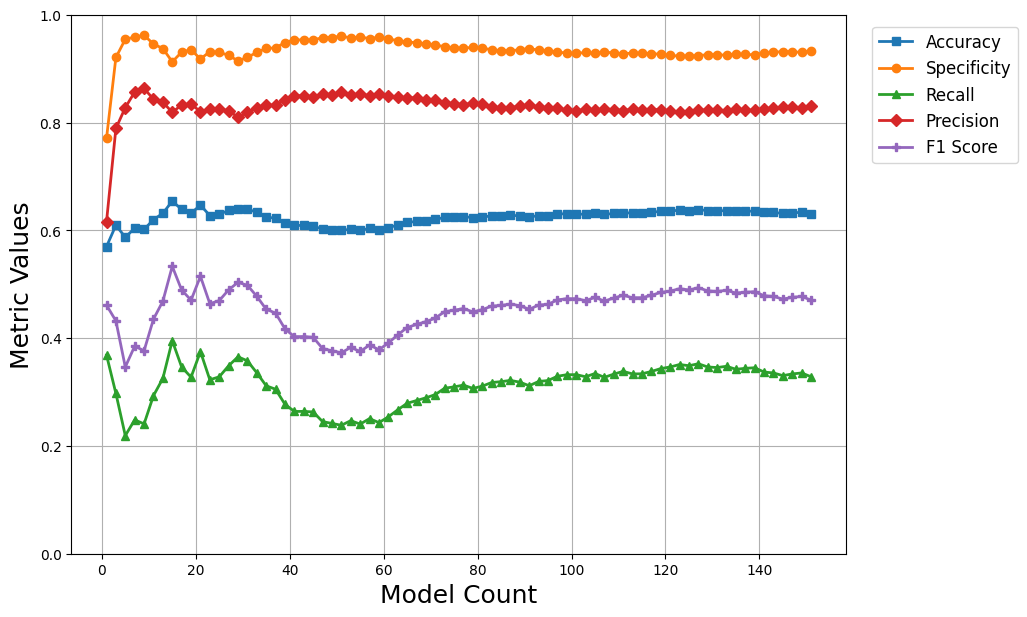

In [49]:
# Plotting results of the Average Weighted Vote Ensemble
plot_ensemble(ensemble, x_valid, y_valid, model_count, threshold, is_merit = True, title = "Valid Weighted Vote", path = "WeightedVote.pdf")

# Plotting results of the Equal Vote Ensemble
plot_ensemble(ensemble, x_valid, y_valid, model_count, threshold, is_merit = False, title = "Valid Equal Vote", path = "EqualVote.pdf")

### Based on the ensemble plots, 29 models seem to be the best.

In [ ]:
use_count = 29

## Evaluating Ensemble

In [65]:
# Evaluating the Average Weighted Vote Ensemble
with tf.device('/cpu:0'):
    r_train, _ = ensemble.evaluate(x_train, y_train, use_count, is_merit=True, is_loaded=True)
    print("Done with Training")
    r_valid, _ = ensemble.evaluate(x_valid, y_valid, use_count, is_merit=True, is_loaded=True)
    print("Done with Validation")
    r_test, _ = ensemble.evaluate(x_test, y_test, use_count, is_merit=True, is_loaded=True)
    print("Done with Testing")

2304/2304 [==============================] - 19s 8ms/step
Accuracy: 0.6558566623263888
Specificity: 0.9369948467588826
Recall:  0.37462694666015517
Precision:  0.8559915690285785
F1:  0.5211647700466133
Done with Training
480/480 [==============================] - 3s 7ms/step
Accuracy: 0.6302734375
Specificity: 0.9325974025974026
Recall:  0.3263707571801567
Precision:  0.8280887711162637
F1:  0.46820863376720656
Done with Validation
480/480 [==============================] - 3s 7ms/step
Accuracy: 0.63984375
Specificity: 0.9330205890018244
Recall:  0.34712464220660944
Precision:  0.8384663733500943
F1:  0.4909827015090173
Done with Testing


In [64]:
# Evaluating the Equal Vote Ensemble
with tf.device('/cpu:0'):
    r_train, _ = ensemble.evaluate(x_train, y_train, use_count, is_merit=False, is_loaded=True)
    print("Done with Training")
    r_valid, _ = ensemble.evaluate(x_valid, y_valid, use_count, is_merit=False, is_loaded=True)
    print("Done with Validation")
    r_test, _ = ensemble.evaluate(x_test, y_test, use_count, is_merit=False, is_loaded=True)
    print("Done with Testing")

2304/2304 [==============================] - 18s 8ms/step
Accuracy: 0.6695421006944444
Specificity: 0.9205315975047464
Recall:  0.4184708882739161
Precision:  0.8403617740002179
F1:  0.5587191190320944
Done with Training
480/480 [==============================] - 4s 7ms/step
Accuracy: 0.644921875
Specificity: 0.9132467532467532
Recall:  0.3751958224543081
Precision:  0.8114059853190287
F1:  0.5131226566684519
Done with Validation
480/480 [==============================] - 3s 7ms/step
Accuracy: 0.6567708333333333
Specificity: 0.917253062288246
Recall:  0.3966952901379131
Precision:  0.8276330076004343
F1:  0.5363236587510993
Done with Testing
